## Preparation

Now we have a closer look at the results, specifically how confident AlphaFold3 is in its prediction!
First we need some python modules. Execute the cell below to load them into the notebook!

In [1]:
from Bio.PDB.MMCIF2Dict import MMCIF2Dict
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Now we need to find the output files we need:

In [2]:
# name variable from the MSA input file / json file
project_name = "test"

# working directory 
ALPHAFOLD_WORKING_DIR="afold_test/"

# inference output directory
ALPHAFOLD_RESULTS_DIR_PART2 = ALPHAFOLD_WORKING_DIR+"output_gpu" 

Now we use this information to find the relevant files from the AlphaFold3 output directly. This includes:
* the structure file ending in cif
* the confidences and summary confidences as *json files

In [3]:
# get residue info from cif file
pdb_info = MMCIF2Dict(ALPHAFOLD_RESULTS_DIR_PART2+"/"+project_name+"/"+project_name+"_model.cif")

with open(ALPHAFOLD_RESULTS_DIR_PART2+"/"+project_name+"/"+project_name+"_summary_confidences.json") as file:
    confidence = json.load(file)
    
with open(ALPHAFOLD_RESULTS_DIR_PART2+"/"+project_name+"/"+project_name+"_confidences.json") as file:
    pae = json.load(file)

# translate chain indices
chains = [chr(item) for item in range(ord("A"), ord("Z") + 1)][:len(confidence["chain_iptm"])]

## Overal Confidence Levels


The clash value indicates if the structure has a significant number of clasing atoms (more than 50% or a chain or a chain with more than 100 atoms).

In [4]:
confidence["has_clash"]

0.0

The **predicted template modeling (pTM)** score measures the accuracy of the entire structure. It ranges from 0-1. A pTM score above 0.5 means the overal predicted ford for the complex might be similar to the true structure.
For more information see https://doi.org/10.1093/BIOINFORMATICS/BTQ066.

Note that TM score is strict for small structures or short chains (fewer than 20 tolkens). For these cases PAE and pLDDT may be more indicative of prediction quality.

In [5]:
confidence["ptm"]

0.62

The **interface predicted template modeling (ipTM)** score measures accuracy of the predicted relative positions of the subunits within the complex. It ranges from 0 to 1. Values higher than 0.8 represent confident high-quality predictions, while values below 0.6 suggest likely a failed prediction.

In [6]:
confidence["iptm"]

0.63

The **predicted local distance difference test (pLDDT)** is a local confidence measure, calculated for each atom and residue. It uses a 0-100 scale, where higher values indicate higher confidence. Values above 90 indicate high confidence, a value below 50 indicates low confidence in this part of the predicted structure.

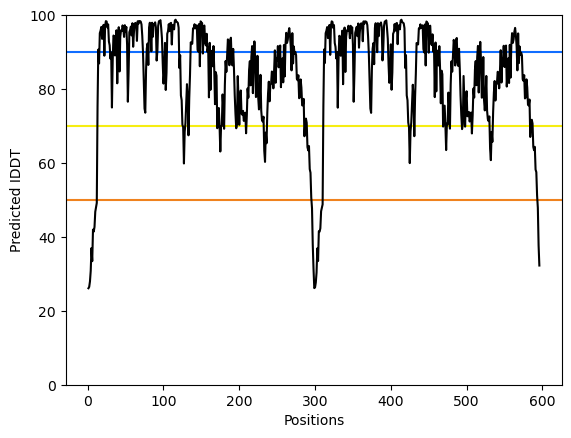

In [7]:
x = np.array([int(x) for x in pdb_info['_ma_qa_metric_local.ordinal_id']])
y = np.array([float(x) for x in pdb_info['_ma_qa_metric_local.metric_value']])

regions = [
    {'label': 'Very High', 'color': '#106dff', 'bottom': 90, 'top': 100},
    {'label': 'Confident', 'color': '#f6ed12', 'bottom': 70, 'top': 90},
    {'label': 'Low', 'color': '#ef821e', 'bottom': 50, 'top': 70},
]


# Add colored horizontal lines for each confidence interval
for region in regions:
    plt.axhline(region['bottom'], color=region['color'])

plt.plot(x, y, color='black')

plt.ylim(0,100)
plt.xlabel("Positions")
plt.ylabel("Predicted IDDT")
plt.show()

The **predicted aligned error (PAE)** is an estimate of the error in the relative postion and orientation between two residues, molecules or ions in the predicted structure. Higher values indicate lower confidence.


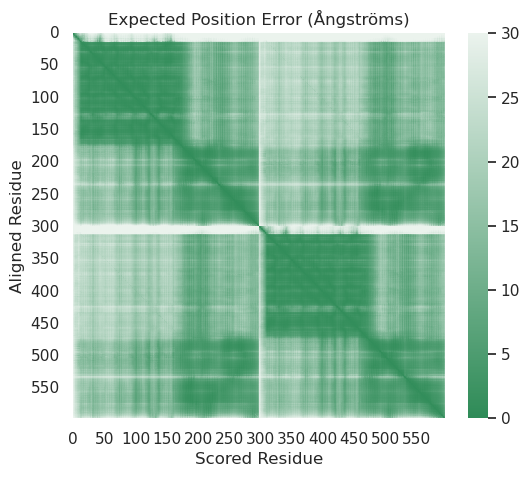

In [8]:
sns.set_theme(rc={'figure.figsize':(6,5)})

ax = sns.heatmap(pae['pae'],  xticklabels = 50, yticklabels = 50, # if the axis labels look weird, feel free to adjust this parameters
            cmap=sns.light_palette("seagreen", reverse=True, as_cmap=True), vmin=0, vmax=30)
ax.tick_params(left=False, bottom=False)
ax.set_title("Expected Position Error (Ångströms)")

plt.yticks(rotation=0) 
plt.xlabel('Scored Residue')
plt.ylabel('Aligned Residue')

plt.show()

## Chain Confidence Levels

Chain confidence levels allow a breakdown of the overall confidence levels onto individual chains. The **chain pTM** contains the pTM restricted to the respective chain. This can be used for ranking individual chains, independent of their interactions.The **chain ipTM** gives the average confidence per chain in the interafce between each chain and all other chains. It can be used to ranking specific chains with a focus on their interaction with the rest of the complex. This is often the case for ligands. 

Note that the chain ipTM is not available for ions.

In [9]:
chain_confidence = pd.DataFrame(
            index=chains,
            data= np.column_stack([confidence["chain_ptm"], confidence["chain_iptm"]]),
            columns = ["Chain pTM Score", "Chain ipTM Score"]
            )
chain_confidence

,Chain pTM Score,Chain ipTM Score
A,0.68,0.63
B,0.68,0.63


## Chain Pair Confidence Levels
Chain pair confidence levels show values with respect to all other individual chains in matrix format.

The diagonal elements (i, i) contain the **pTM** restricted to chain i. Off-diagonal elements (i, j) of the array contain the **ipTM** restricted to tokens from chains i and j.  This inforamtion can be used for ranking a specific interface between two chains, when you know that they interact, e.g. for antibody-antigen interactions.

Note that the chain restrictred pTM and ipTM are not available for ions.

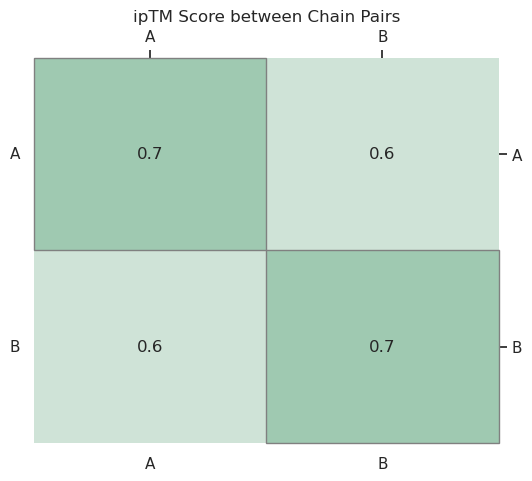

In [10]:
chain_pair_iptm = pd.DataFrame(confidence["chain_pair_iptm"],index=chains, columns=chains)

ax = sns.heatmap(chain_pair_iptm, annot=True, fmt=".1f", 
            cmap= sns.light_palette("seagreen", as_cmap=True), vmin=0.6, vmax=0.8, cbar=False)
ax.tick_params(right=True, top=True, labelright=True, labeltop=True,rotation=0)
ax.set_title("ipTM Score between Chain Pairs")

for i in range(len([x for x in confidence["chain_ptm"]if str(x) != 'None'])):
    index_of_element_to_outline = [i, i]
    rect = plt.Rectangle(index_of_element_to_outline, 1,1, color="gray", 
                         linewidth=1, fill=False, clip_on=False)
    ax.add_patch(rect)

plt.show()

This plot show the lowest predicted aligne error (PAE) value across rows restricted to chain i and columns restricted to chain j. This has been found to correlate with whether two chains interact or not, and in some cases can be used to distinguish binders from non-binders. 

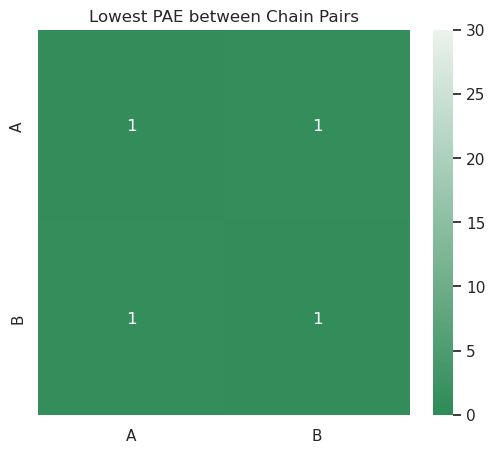

In [11]:
chain_pair_pae = pd.DataFrame(confidence['chain_pair_pae_min'],index=chains, columns=chains)

ax = sns.heatmap(chain_pair_pae, annot=True, fmt=".0f", 
            cmap=sns.light_palette("seagreen", reverse=True, as_cmap=True), vmin=0, vmax=30)
ax.set_title("Lowest PAE between Chain Pairs")
plt.show()